<a href="https://colab.research.google.com/github/FabrizioBettetti/Machine-learning/blob/main/Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_images.ndim   #Rank

3

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images.dtype

dtype('uint8')

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

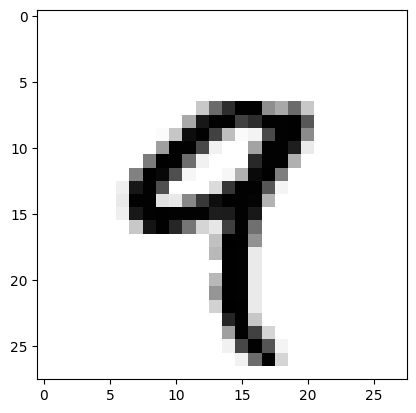

In [7]:
import matplotlib.pyplot as plt

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [8]:
train_labels[4]

np.uint8(9)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

In [11]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [13]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [15]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8718 - loss: 0.4395
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9659 - loss: 0.1187
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9792 - loss: 0.0722
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9867 - loss: 0.0481
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - loss: 0.0382


In [16]:
test_digits = test_images[:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


array([2.9099149e-06, 1.3294486e-08, 1.1807588e-05, 7.9778758e-05,
       1.6126517e-11, 1.0303422e-08, 1.3005742e-10, 9.9989820e-01,
       1.3307026e-07, 7.1372956e-06], dtype=float32)

In [17]:
predictions[0].argmax()   #Index of highest probability

np.int64(7)

In [18]:
predictions[0][7]

np.float32(0.9998982)

In [19]:
test_labels[0]

np.uint8(7)

In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test_acc: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9770 - loss: 0.0780
test_acc: 0.9799000024795532


##From scratch

In [21]:
import tensorflow as tf

class NaiveDense:
  def __init__(self, input_size, output_size, activation):   #input_size = 28 * 28 = 784, output_size = 512
    self.activation = activation

    w_shape = (input_size, output_size)   #(784, 512)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)   #Uniform distribution on the interval [minval, maxval)
    self.W = tf.Variable(w_initial_value)

    b_shape = (output_size,)   #(512,)
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)

  def __call__(self, inputs):   #inputs with shape (128, 784)
    return self.activation(tf.matmul(inputs, self.W) + self.b)   #(128, 784) matmul (784, 512) + (512,) = (128, 512)  (self.b broadcasted to (128, 512))

  @property
  def weights(self):
    return [self.W, self.b]

In [22]:
class NaiveSequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [23]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [24]:
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):   #images: train images of shape (60000, 784); labels: train labels of shape (60000,)
    assert len(images) == len(labels)   #len return the number of elements in the first axis (60000 == 60000)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(images) / batch_size)   #ceil(60000 / 128) = 469

  def next(self):
    images = self.images[self.index : self.index + self.batch_size]   #[] operator acts on first axis. Extracts 128 images (except last batch)
    labels = self.labels[self.index : self.index + self.batch_size]   #Extracts 128 labels (except last batch)
    self.index += self.batch_size   #Move index to the start of next batch size
    return images, labels

In [25]:
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    predictions = model(images_batch)   #Invoke __call__ of NaiveSequential with argument inputs = images_batch
    per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
    average_loss = tf.reduce_mean(per_sample_losses)
  gradients = tape.gradient(average_loss, model.weights)
  update_weights(gradients, model.weights)
  return average_loss

In [26]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
  optimizer.apply_gradients(zip(gradients, weights))

In [27]:
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f'epoch {epoch_counter}')
    batch_generator = BatchGenerator(images, labels, batch_size)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f'loss at batch {batch_counter}: {loss:.2f}')

In [28]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

epoch 0
loss at batch 0: 6.18
loss at batch 100: 2.19
loss at batch 200: 2.16
loss at batch 300: 2.07
loss at batch 400: 2.21
epoch 1
loss at batch 0: 1.91
loss at batch 100: 1.84
loss at batch 200: 1.79
loss at batch 300: 1.69
loss at batch 400: 1.82
epoch 2
loss at batch 0: 1.59
loss at batch 100: 1.54
loss at batch 200: 1.47
loss at batch 300: 1.40
loss at batch 400: 1.51
epoch 3
loss at batch 0: 1.33
loss at batch 100: 1.31
loss at batch 200: 1.21
loss at batch 300: 1.19
loss at batch 400: 1.27
epoch 4
loss at batch 0: 1.13
loss at batch 100: 1.14
loss at batch 200: 1.02
loss at batch 300: 1.03
loss at batch 400: 1.11
epoch 5
loss at batch 0: 0.98
loss at batch 100: 1.00
loss at batch 200: 0.88
loss at batch 300: 0.91
loss at batch 400: 0.99
epoch 6
loss at batch 0: 0.87
loss at batch 100: 0.90
loss at batch 200: 0.78
loss at batch 300: 0.82
loss at batch 400: 0.90
epoch 7
loss at batch 0: 0.79
loss at batch 100: 0.81
loss at batch 200: 0.70
loss at batch 300: 0.75
loss at batch 40

In [29]:
import numpy as np

predictions = model(test_images)   #predictions shape: (10000, 10)
predictions = predictions.numpy()   #predictions shape: (10000, 10)
predicted_labels = np.argmax(predictions, axis=1)   #predicted_labels shape: (10000,) (extract the index of the maximum value in the second axis)
matches = predicted_labels == test_labels
print(f'accuracy: {matches.mean():.2f}')

accuracy: 0.82


##Generalization

Noise channels, all-zero channels

In [30]:
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zero_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

In [31]:
train_images_with_noise_channels.shape

(60000, 1568)

In [32]:
train_images_with_zero_channels.shape

(60000, 1568)

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
  model = keras.Sequential([
      layers.Dense(512, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = get_model()
history_noise = model.fit(train_images_with_noise_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

model = get_model()
history_zeros = model.fit(train_images_with_zero_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6982 - loss: 1.0519 - val_accuracy: 0.9223 - val_loss: 0.2630
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.2806 - val_accuracy: 0.9457 - val_loss: 0.1838
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9458 - loss: 0.1764 - val_accuracy: 0.9459 - val_loss: 0.1736
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9622 - loss: 0.1222 - val_accuracy: 0.9593 - val_loss: 0.1343
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9739 - loss: 0.0843 - val_accuracy: 0.9644 - val_loss: 0.1270
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0614 - val_accuracy: 0.9624 - val_loss: 0.1267
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9859 - loss: 0.0465 - val_accuracy: 0.9465 - val_loss: 0.1818
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9897 - loss: 0.0350 - val_accuracy: 0.

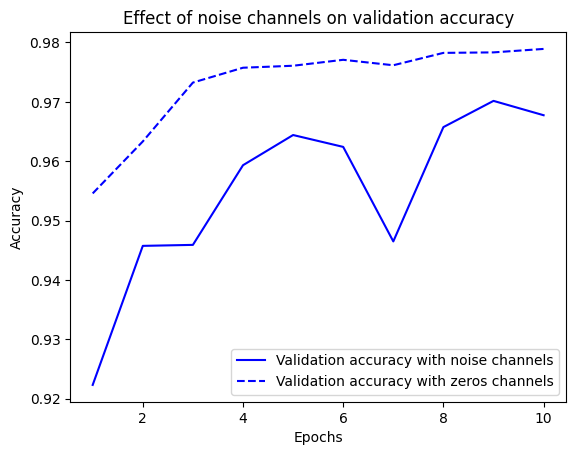

In [34]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history['val_accuracy']
val_acc_zeros = history_zeros.history['val_accuracy']
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, 'b-', label='Validation accuracy with noise channels')
plt.plot(epochs, val_acc_zeros, 'b--', label='Validation accuracy with zeros channels')
plt.title('Effect of noise channels on validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Randomly shuffled labels

In [35]:
random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, random_train_labels, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1034 - loss: 2.3317 - val_accuracy: 0.1031 - val_loss: 2.3051
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1223 - loss: 2.2970 - val_accuracy: 0.1043 - val_loss: 2.3106
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1287 - loss: 2.2898 - val_accuracy: 0.1039 - val_loss: 2.3162
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1407 - loss: 2.2773 - val_accuracy: 0.1001 - val_loss: 2.3222
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1524 - loss: 2.2612 - val_accuracy: 0.1030 - val_loss: 2.3341
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1669 - loss: 2.2413 - val_accuracy: 0.1026 - val_loss: 2.3506
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1843 - loss: 2.2145 - val_accuracy: 0.1007 - val_loss: 2.3715
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1994 - loss: 2.1882 - val_accu

In [36]:
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1008 - loss: 7.9947


[7.709334373474121, 0.10329999774694443]